## Adiabatic Quantum Computing workflow for Computational Materials Chemistry


In [49]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.ext.matproj import MPRester
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view
import copy
import time
import itertools

import numpy as np
import pandas as pd

The **objectives** are:
- maximising the number of bonds

$$
E_{bonds} = - p \sum_{i}^{N_{atoms}}\sum_{j>i}^{N_{atoms}} A_{i,j} x_{i} x_{j} 
$$

where $A_{i,j} = 1$ if atoms i and j are bonded and $A_{i,j} = 0$ otherwise.

- minimising the number of undercoordinated atoms

$$
E_{coord} = - q \sum_{i}^{N_{atoms}} \sum_{j}^{N^{i}_{neigh}}\sum_{k>j}^{N^{i}_{neigh}}  x_{j} x_{k} 
$$

Where $N^{i}_{bonds}$ is the number of neighbours the atom i has in absence of vacancies.

The scaling factors p and q in the above expressions can be use to determine to weight of the bonds/coordination into the final energy.\

The **constraints** are defined in terms of number of vacancies:

$$
\sum_{i}^{N_{atoms}} x_{i} = N_{atoms} - N_{vacancies} 
$$

that can be expressed as:

$$
\sum_{i}^{N_{atoms}} x_{i} - (N_{atoms} - N_{vacancies}) = 0 
$$

# The functions

In [50]:
def build_adjacency_matrix(structure):
    # structure = pymatgen Structure object
    
    import numpy as np
    
    distance_matrix_pbc = np.round(structure.distance_matrix,5)

    shells = np.unique(distance_matrix_pbc[0])

    adjacency_matrix = np.round(distance_matrix_pbc,5) == np.round(shells[1],5)
    adjacency_matrix = adjacency_matrix.astype(int)
    
    return adjacency_matrix

In [51]:
def build_quadratic_model(structure,use_coord = True, num_vacancies = 0, 
                          weight_1=10, weight_2 = 1, lagrange = 1000):
    # structure = pymatgen Structure object
    # weight_1 = weight for the bond energy objective
    # weight_1 = weight for the bond energy objective
    # lagrange = weight for the number of vacancies constraint
    
    from dimod import BinaryQuadraticModel
    
    X = np.arange(structure.num_sites)
    
    adjacency_matrix = build_adjacency_matrix(structure)

    Q = np.triu(-weight_1*adjacency_matrix.astype(int),0)
    
    bqm = BinaryQuadraticModel.from_qubo(Q)
    
    if use_coord == True:
        for i in range(structure.num_sites):  
            neighbours = np.where(adjacency_matrix[i,:] == 1)[0]
            for j in range(len(neighbours)):
                for k in range(len(neighbours)):
                    if k > j:
                        bqm.add_interaction(X[neighbours[j]],X[neighbours[k]],weight_2)
    

    if num_vacancies == 0:
        print('Unconstrained quadratic model used')
        
        return bqm
    elif num_vacancies > 0:
        print('Unconstrained quadratic model + contraints used')
        
        c_n_vacancies = [(i,1) for i in X]

        bqm.add_linear_equality_constraint(
                c_n_vacancies,
                constant= -(structure.num_sites-num_vacancies),
                lagrange_multiplier = lagrange
                )

        return bqm
    
    else:
        print('Please select a positive integer number of vacancies')
     
        return None

In [52]:
def build_constrained_quadratic_model(structure,use_coord = True, num_vacancies = 0, 
                          weight_1=10, weight_2 = 1, lagrange = 1000):
    # structure = pymatgen Structure object
    # weight_1 = weight for the bond energy objective
    # weight_1 = weight for the bond energy objective
    # lagrange = weight for the number of vacancies constraint
    
    from dimod import BinaryQuadraticModel, ConstrainedQuadraticModel, Binary, quicksum
    from dwave.system import LeapHybridCQMSampler
    
    if num_vacancies == 0:
        print('No constraints to apply - Unconstrained quadratic model used instead')
        
        return build_quadratic_model(structure,use_coord = use_coord, num_vacancies = 0, 
                          weight_1=weight_1, weight_2 = weight_2, lagrange = lagrange)
    elif num_vacancies < 0:
        print('Please select a positive integer number of vacancies')
     
        return None
    
    elif num_vacancies > 0:
        print('Constrained quadratic model')
    
        atoms = [Binary(i) for i in range(structure.num_sites)]

        atoms = np.array(atoms)

        cqm = ConstrainedQuadraticModel()

        c = np.arange(structure.num_sites)

        adjacency_matrix = build_adjacency_matrix(structure)

        Q = np.triu(-weight_1*adjacency_matrix.astype(int),0)

        bqm = BinaryQuadraticModel.from_qubo(Q)

        bqm = BinaryQuadraticModel.from_qubo(Q)

        if use_coord == True:
            for i in range(structure.num_sites):  
                neighbours = np.where(adjacency_matrix[i,:] == 1)[0]
                for j in range(len(neighbours)):
                    for k in range(len(neighbours)):
                        if k > j:
                            bqm.add_interaction(c[neighbours[j]],c[neighbours[k]],weight_2)

        cqm.set_objective(bqm)

        #set the constraint: number of vacancies
        cqm.add_constraint(quicksum(atoms[i] for i in range(structure.num_sites)) \
                           == (structure.num_sites - num_vacancies), label='Num vacancies')

        return cqm
    
    else:
        print('Something is wrong with the number of vacancies')
        
        return None
    
    

In [53]:
def run_anneal(bqm,num_reads = 1000, time_limit=5, chain_strength = None, label='Test anneal', dataframe = True, 
               remove_broken_chains = True, return_config_E = False):
    
    
    if 'BinaryQuadraticModel' in str(type(bqm)):
        from dwave.system import EmbeddingComposite, DWaveSampler

        sampler = EmbeddingComposite(DWaveSampler())
        
        if chain_strength != None:
            result = sampler.sample(bqm, num_reads = num_reads, chain_strength = chain_strength,  label=label)
        else:
            result = sampler.sample(bqm, num_reads = num_reads, label=label)
        
    elif 'ConstrainedQuadraticModel' in str(type(bqm)):
        from dwave.system import LeapHybridCQMSampler
        
        cqm_sampler = LeapHybridCQMSampler()
        
        result = cqm_sampler.sample_cqm(bqm,time_limit=time_limit)
    
    elif 'DiscreteQuadraticModel' in str(type(bqm)):
        
        from dwave.system import LeapHybridDQMSampler

        dqm_sampler = LeapHybridDQMSampler()
        
        result = dqm_sampler.sample_dqm(test,time_limit=time_limit)
      
    
    if dataframe == True:
        result_df = result.to_pandas_dataframe()
        
        if 'BinaryQuadraticModel' in str(type(bqm)):
            if remove_broken_chains == True and return_config_E == True:
                result_df = result_df[result_df['chain_break_fraction'] == 0.]
            
            if return_config_E == True:
                n_atoms = len(bqm.to_numpy_vectors()[0])

                config = result_df.iloc[:,0:n_atoms].to_numpy()
                energies = result_df['energy'].to_numpy()

                return result_df, config, energies
            
        else:
            return result_df
        
    else:
        return result

In [54]:
def find_all_structures(dataframe, min_energy = 0., return_count = False, sort_config = False, sort_energy = False):
    
    n_atoms = len([i for i in dataframe.columns if type(i) == int])
    
    energies = dataframe['energy'].to_numpy()
    
    below_min_energy = np.where(energies < min_energy)[0]

    config = dataframe.iloc[:,0:n_atoms].to_numpy()[below_min_energy]

    energies = energies[below_min_energy]

    multiplicity = dataframe['num_occurrences'].to_numpy()[below_min_energy]
    
    if sort_config == True and sort_energy == False:
        config_sorted = []
        for i, conf in enumerate(config):
            config_sorted.append(int(''.join([str(x) for x in conf])))

        sorting = np.argsort(np.array(config_sorted))   
 
        config = config[sorting]
        energies = energies[sorting]
        multiplicity = multiplicity[sorting]
    
    elif sort_energy == True:
        print('Implement this first')
        
    return config, energies, multiplicity
        

In [55]:
def find_unique_E_structures(dataframe, min_energy = 0, return_count = False):
    # energy = list of all the energies returned by the anneal
    # configurations = list of all configurations corresponding to a certain energy
    
    n_atoms = len([i for i in dataframe.columns if type(i) == int])

    config = dataframe.iloc[:,0:n_atoms].to_numpy()

    energies = dataframe['energy'].to_numpy()

    below_min_energy = np.where(np.unique(energies,return_index=True)[0] < min_energy)[0]

    return np.unique(energies,return_index=True)[0][below_min_energy], np.unique(energies,return_index=True)[1][below_min_energy]

In [56]:
def display_low_E_structures(structure,energies,configurations, min_energy = 0, view = False):
    
    low_energy, low_config = find_unique_E_structures(energies,configurations,min_energy = min_energy)
    
    low_energy_structures = []
    
    for i in low_config:
        structure_2 = copy.deepcopy(structure)
        for j in np.where(configurations[i] == 0)[0]:
            structure_2.replace(j,1)
        low_energy_structures.append(AseAtomsAdaptor().get_atoms(structure_2))
        
        if view == True:
            view(AseAtomsAdaptor().get_atoms(structure_2))
    
    return low_energy_structures

In [57]:
def find_coordination(structure, configurations, structure_indices, return_analysis = False):
    # Find the coordination of each site

    first_neighbour_dist = np.round(np.unique(structure.distance_matrix[0])[1],5)
    
    neighbours = []
    for i in structure_indices:
        neigh = []
        structure_2 = copy.deepcopy(structure)
        for j in np.where(configurations[i] == 0)[0]:
            structure_2.replace(j,1)
        
        for atom in range(structure_2.num_sites):
            bonded = np.where(build_adjacency_matrix(structure)[atom] == 1.)[0]
            if structure_2.atomic_numbers[atom] == 1:
                neigh.append(-1)
            else:
                neigh.append(int(np.sum(np.array(structure_2.atomic_numbers)[bonded])/6))
        
        neighbours.append(neigh)
    
    analysis = []
    max_bond = max_n_bonds = np.sum(adjacency_matrix[0])
    if return_analysis == True:
        for line in np.array(neighbours):
            analysis_tmp = []
            for i in range(max_bond):
                analysis_tmp.append(np.sum(line == max_bond-i))
            analysis.append(analysis_tmp)
        return neighbours, analysis

    
    return neighbours

In [58]:
def find_num_broken_bonds(structure, configurations, structure_indices):
    # Find the number of broken bonds per structure
    
    adjacency_matrix = build_adjacency_matrix(structure)
    
    max_n_bonds = np.sum(adjacency_matrix)
    
    n_broken_bonds = []
    
    for i in structure_indices:
        n_broken_bonds.append((max_n_bonds - np.matmul(config[i],np.matmul(config[i],adjacency_matrix)))/2)
    
    return n_broken_bonds

In [231]:
def save_json(structure,dataframe, bqm, use_coord = True, num_vacancies = 0, 
                          weight_1=10, weight_2 = 1, lagrange = 1000,
              num_reads = 1000, time_limit=5, label='Test anneal', 
              remove_broken_chains = True, file_path = 'data', file_name = '', save_qubo = True,
             low_exact = None, chain_strength = None):
    
    # save the dataframe as a json file
    
    import json
    from datetime import datetime,timezone
    from os import path
    import time
    
    if 'BinaryQuadraticModel' in str(type(bqm)):
        model = 'bqm'
        time_limit = 0
    elif 'ConstrainedQuadraticModel' in str(type(bqm)):
        model = 'cqm'
        num_reads = 0
    
    date_time = datetime.now(timezone.utc).strftime("%m/%d/%Y, %H:%M:%S")
    time_stamp = int(time.time())
    
    if save_qubo == True:
        qubo_matrix = build_qubo_matrix(bqm).flatten().tolist()
    elif save_qubo == False:
        qubo_matrix = None
    
    if chain_strength == None:
        chain_strength = -1
        
    param_dict = {'date_time': date_time,
                  'time_stamp': time_stamp,
                  'structure': structure.composition.formula,
                  'N atoms' : structure.num_sites,
                    'model': model,
                  'use_coord' : use_coord,
                  'num_vacancies': num_vacancies,
                  'weight_1': weight_1,
                  'weight_2' : weight_2,
                  'lagrange': lagrange,
                     'num_reads' : num_reads, 
                  'time_limit': time_limit,
                  'label':label, 
                  'remove_broken_chains' : remove_broken_chains,
                  'chain_strength' : chain_strength,
                  'low_exact': low_exact,
                  #'qubo_matrix': qubo_matrix,
                  'qubo_matrix': qubo_matrix
                     
    }
    
    json_string = dataframe.to_json()
    
    json_object = json.loads(json_string)
    json_object['parameters'] = param_dict

    name = file_name + '_%s_%s_v%s_c%s_w1%s_w2%s_l%s_r%s_t%s_%s.json'%(structure.composition.formula,
                                                                    model,num_vacancies,str(use_coord)[0],
                                                                    weight_1,weight_2,lagrange,num_reads,
                                                                    
                                                                    time_limit,time_stamp)
    
    file_name = path.join(file_path,name)

    with open(file_name, 'w') as f:
        json.dump(json_object, f)

In [60]:
def load_json(file_name, return_param = True, return_qubo = True):
    
    import numpy as np
    import pandas as pd
    import json
    
    # Read a previously saved dataframe
    
    with open(file_name) as f:
        data = json.load(f)
    
    param = data.pop('parameters')
    qubo_matrix = np.array(param.pop('qubo_matrix'))
    param_df = pd.DataFrame(param,index=['Values']).transpose()
    
    dataframe = pd.DataFrame.from_dict(data)
    
    if return_param == True and return_qubo == True:
        return dataframe, param_df, qubo_matrix
    elif return_param == True and return_qubo == False:
        return dataframe, param_df
    elif return_param == False and return_qubo == False:
        return dataframe

In [61]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    if np.around(az,6) ==  np.around(2*np.pi,6) \
    or np.around(az,6) ==  -np.around(2*np.pi,6):
        az = 0.
    if np.around(az,6) < 0.:
        az = np.round(2*np.pi+az,6)
    return [round(az,6), round(el,6), round(r,6)]

In [62]:
#Think about this in terms of a binary vector instead
def build_descriptor(structure):
    max_shell = 2
    centered_sph_coords = []
    centered_sph_coords_structure = []
    neighbours_spatial_dist = []
    neighbours_spatial_dist_all = []
    import time
    for k,structure in enumerate(structures): 
        time0 = time.time()
        neighbours_spatial_dist = []

        for j in range(structure.num_sites):
            centered_sph_coords = []
            neighbours_spatial_dist_atom = []

            for n in range(max_shell+1):
                atom_indices = np.where(np.round(structure.distance_matrix[j],5) == np.round(shells[n],5))[0].tolist()
                centered_sph_coords = []
                for i in atom_indices:

                    translation_vector = structure.sites[j].distance_and_image(structure.sites[i])[1]
                    new_cart_coords = structure.cart_coords[i]+(translation_vector*structure.lattice.abc)
                    centered_cart_coords = new_cart_coords-structure.cart_coords[j] 

                    centered_sph_coords.append(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))        

                spatial_distribution = np.argsort(np.array(centered_sph_coords)[:,1]*10 +\
                                                  np.array(centered_sph_coords)[:,0])


                neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atom_indices)[spatial_distribution]]).tolist())
            neighbours_spatial_dist.append(neighbours_spatial_dist_atom)
        #print(time.time()-time0)
        neighbours_spatial_dist_all.append(neighbours_spatial_dist) 
    #neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all) 

In [63]:
def find_equivalent_structures(): 
    pass

In [64]:
def find_symmetry_equivalent_structures():
    pass

In [65]:
def classical_solver(len_x, bqm, sort = True):
    
    # Calculate the energy of all possible solutions for a binary vector of len len_x
    # whose Hamiltonian is bqm
    
    x_classical = np.array(list(itertools.product([0, 1], repeat=len_x)))
    
    if sort == True:
        sorting = np.argsort(np.sum(x_classical,axis=1))
        
        x_classical = x_classical[sorting]
    
    qubo_matrix = build_qubo_matrix(bqm)
    
    E_tmp = -np.matmul(x_classical,qubo_matrix)
    E_classical = np.sum(x_classical*E_tmp,axis=1)
    
    return E_classical

In [337]:
def build_qubo_matrix(bqm, transpose= True):
    
    # Returns the qubo matrix from a bqm model (cqm notr supported)
    
    # Build a n_atoms x n_atoms matrix containing only 0s    
    num_items = len(bqm.to_numpy_vectors().linear_biases)   
    qubo_matrix = np.array([[0]*num_items]*num_items)
    
    # Add the h_ii elements (diagonal)
    np.fill_diagonal(qubo_matrix,bqm.to_numpy_vectors().linear_biases)
    
    # Add the J_ij (off diagonal elements)
    num_non_zero_elements = len(bqm.to_numpy_vectors().quadratic.row_indices)

    row_indices = bqm.to_numpy_vectors().quadratic.row_indices
    col_indices = bqm.to_numpy_vectors().quadratic.col_indices

    biases = bqm.to_numpy_vectors().quadratic.biases

    #Assign the quadratic biases to the i,j elements
    for i in range(num_non_zero_elements):
        qubo_matrix[row_indices[i]][col_indices[i]] = biases[i]
        
    #Transpose the matrix (the model builds the lower left side of the matrix, 
    #it is hermitian, so it doesn't matter)  
    if transpose == True:
        qubo_matrix = qubo_matrix.transpose()
    
    return qubo_matrix

In [67]:
def find_exact_solutions(bqm):
    
    if 'BinaryQuadraticModel' in str(type(bqm)):
        
        from dimod import ExactSolver
        
        return ExactSolver().sample(bqm).to_pandas_dataframe()
    
    elif 'ConstrainedQuadraticModel' in str(type(bqm)):
        
        from dimod import ExactCQMSolver
        
        return ExactCQMSolver().sample_cqm(bqm).to_pandas_dataframe()

In [68]:
def build_graph(structure):
    # Generate the graph from the pymatgen structure
    
    from pymatgen.analysis.graphs import StructureGraph
    from pymatgen.analysis.local_env import NearNeighbors, MinimumDistanceNN
    from networkx import Graph
    
    G = StructureGraph.with_local_env_strategy(structure,MinimumDistanceNN())
    
    return Graph(G.graph)
    

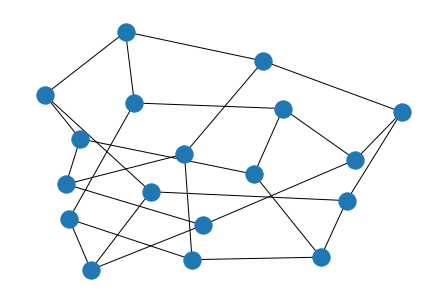

In [84]:
import networkx as nx
G = build_graph(structure)
nx.draw(G)

In [610]:
def build_binary_quadratic_model_discrete(structure,species,concentrations, parameters, weight=100, max_neigh = 1):
    '''# structure = pymatgen Structure object
    # weight_1 = weight for the bond energy objective
    # weight_1 = weight for the bond energy objective
    # lagrange = weight for the number of vacancies constraint'''
    
    
    from dimod import BinaryQuadraticModel, Binary
    
    num_sites = structure.num_sites
    num_species = len(species)
    
    X = np.arange(structure.num_sites)
    
    adjacency_matrix = build_adjacency_matrix(structure)

    Q = np.triu(adjacency_matrix.astype(int),0)
    
    bqm = BinaryQuadraticModel.empty(vartype='BINARY')

    
    # Add one-hot encoding

    # -1 diagonal
    # 2 off diagonal
    J = np.array([[0]*num_sites*num_species]*(num_sites*num_species))
    for i in range(num_sites*num_species):
        for j in range(i,num_sites*num_species,num_species):            
            J[i,j] = -1
            for k in range(1,num_species-i%num_species):
            #for k in range(1,num_species):
                if j+k < num_sites*num_species:
                    #print(i,j+k)
                    J[i,j+k] = +2
    J = J * weight
    
    
    # Add potentials
    
    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    
    # Generate an all False matrix
    distance_matrix_filter = (distance_matrix == -1)

    
    # Only add the atoms within the shells up to max_neigh 
    for neigh in range(1,max_neigh+1):
        distance_matrix_filter +=  distance_matrix == shells[neigh]
    

    #distance_matrix = distance_matrix*distance_matrix_filter.astype(int)
    
    #print(distance_matrix)
    
    atom_types = np.unique(structure.atomic_numbers)
    
    # Calculate the potentials
    
    # Buckingham
    #loop
    
    species_v = species*num_sites
    
    
    for i in range(num_sites):
        for j in range(i,num_sites):
            if distance_matrix_filter[i,j] == True:
                print(i,j)
        
    
    '''ip_matrix = np.array([[0.]*structure.num_sites]*structure.num_sites)
    for i,atom1 in enumerate(species_v):
        for j,atom2 in enumerate(species_v):
            print(i,j)
            if distance_matrix_filter[i,j] == True: #HERE
                print(atom1,atom2)              '''
                #param = parameters['%s-%s'%(structure.sites[i].specie.symbol,structure.sites[j].specie.symbol)]
                #ip_matrix[i,j] = param[0] * np.exp((-distance_matrix[i,j])/(param[1])) - ((param[2])/((distance_matrix[i,j])**6))
    
    
    
    #print(J)
    return J
    return bqm
    
J = build_binary_quadratic_model_discrete(structure,species=['A','B','C'],concentrations=None,parameters=None)    
#a = build_qubo_matrix(build_binary_quadratic_model_discrete(structure,species=['A','B','C'],concentrations=None,parameters=None) , transpose=False)
#a

0 4
0 5
0 6
1 4
1 5
1 7
2 4
2 6
2 7
3 5
3 6
3 7


In [575]:
x_classical = np.array(([1,0,0]*8))
'''x_classical[0] = 1
x_classical[2] = 1
x_classical[4] = 1'''
qubo_matrix=J
E_tmp = np.matmul(x_classical,qubo_matrix)
print(E_tmp)
weight = 8 * (8 + 1) // 2
E_classical = np.sum(x_classical*E_tmp,axis=0)+weight
E_classical

[-1  2  2 -2  4  4 -3  6  6 -4  8  8 -5 10 10 -6 12 12 -7 14 14 -8 16 16]


0

In [390]:
x_classical

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [600]:
ec = []
for i in range(2,11):
    n = i
    weight = -n * (n + 1) // 2
    #qubo_matrix = np.array([[-1,+2]*n,[0,-1]*n]*n)/weight
    qubo_matrix = np.array([[-1,+2]*n,[0,-1]*n]*n)#*100
    qubo_matrix = np.triu(qubo_matrix,0)
    #print(qubo_matrix)
    x_classical = [1,0]*n
    '''x_classical[0] = 1
    x_classical[2] = 1'''
    E_tmp = np.matmul(x_classical,qubo_matrix)
    #print(E_tmp)
    E_classical = np.sum(x_classical*E_tmp,axis=0)
    ec.append(E_classical)
    print(i,E_classical,-n * (n + 1) // 2)

2 -3 -3
3 -6 -6
4 -10 -10
5 -15 -15
6 -21 -21
7 -28 -28
8 -36 -36
9 -45 -45
10 -55 -55


In [549]:
n = 
print(-n * (n + 1) // 2)

55


In [72]:
def ratio_broken_chains(dataframe):
    # Return how many solutions returned a broken chain
    
    broken = np.sum(dataframe[dataframe['chain_break_fraction'] == 0.]['num_occurrences'].to_numpy())
    total = np.sum(dataframe['num_occurrences'].to_numpy())
    
    return np.round(broken/total,4)

In [217]:
def build_ip_matrix(structure, parameters, max_neigh = 1):
    # build the qubo matrix including the interatomic potentials
    
    # parameters = dictionary of 'AtomicSpecie-AtomicSpecie' : [A,B,C]
    ## parameters = list of atom-atom interactions to describe the Buckingham potential
    
    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    
    # Generate an all False matrix
    distance_matrix_filter = (distance_matrix == -1)
    
    # Only add the atoms within the shells up to max_neigh 
    for neigh in range(1,max_neigh+1):
        distance_matrix_filter +=  distance_matrix == shells[neigh]

    #distance_matrix = distance_matrix*distance_matrix_filter.astype(int)
    
    #print(distance_matrix)
    
    atom_types = np.unique(structure.atomic_numbers)
    
    # Calculate the potentials
    
    # Buckingham
    #loop
    ip_matrix = np.array([[0.]*structure.num_sites]*structure.num_sites)
    for i in range(structure.num_sites):
        for j in range(i,structure.num_sites):
            if distance_matrix_filter[i,j] == True:
                param = parameters['%s-%s'%(structure.sites[i].specie.symbol,structure.sites[j].specie.symbol)]
                ip_matrix[i,j] = param[0] * np.exp((-distance_matrix[i,j])/(param[1])) - ((param[2])/((distance_matrix[i,j])**6))
    
    
    return ip_matrix

In [225]:
def build_quadratic_model_ip(structure, parameters, max_neigh = 1):
    # structure = pymatgen Structure object
    # ip_matrix = interatomic potential matrix (returned by build_ip_matrix)
    
    from dimod import BinaryQuadraticModel
    
    ip_matrix = build_ip_matrix(structure, parameters, max_neigh = max_neigh)
    
    bqm = BinaryQuadraticModel.from_qubo(ip_matrix)
         
    return bqm
    

In [70]:
def build_discrete_quadratic_model_ip(structure,species,concentrations, parameters, max_neigh = 1,):
    # structure = pymatgen Structure object
    # species = list of atomic numbers
    # interaction = interactomic potential given as a matrix element by row
    # concentrations = list of concentrations
    
    # https://github.com/dwave-examples/graph-partitioning
    
    from dimod import DiscreteQuadraticModel
    
    c = np.arange(structure.num_sites)
    
    adjacency_matrix = build_adjacency_matrix(structure)
    
    dqm = DiscreteQuadraticModel()
     
    n_species = len(species)
    concentration_1 = concentrations[0]
    
    n_atoms_species = [int(np.rint(x*structure.num_sites)) for x in concentrations[:-1]]
    n_atoms_species.append(int(np.rint(structure.num_sites-np.sum(c))))


    
    #Make this better (or input?)
    interaction_dict = {}
    index = -1
    for i in range(len(species)):
        for j in range(i,len(species)):
            index += 1
            interaction_dict[(i, j)] = interaction[index]
    
    #This creates a (num_sites*num_species) x (num_sites*num_species) matrix
    #DOES IT INCLUDE THE ONE-HOT ENCODING?
    
    for i in range(structure.num_sites):
        dqm.add_variable(n_species, label=i)
    
    #define linked atoms and bond strength
    for i in range(structure.num_sites):
        for j in np.where(adjacency_matrix[i] == 1)[0]:
            #dqm.set_quadratic(i, j, {(0, 0): cu_cu, (0, 1): cu_zn, (1, 1): zn_zn})
            dqm.set_quadratic(i, j, interaction_dict)
    
    # This imposes a double constraint (on both species)
    for i,conc in enumerate(n_atoms_species):
        concentration_1_v = [(s,i,1) for s in c] #make loop
        print(concentration_1_v)
    
        #Define the concentration as a constraint
        dqm.add_linear_equality_constraint(
                    concentration_1_v,
                    constant= -conc,
                    lagrange_multiplier = lagrange
                    )
    
    '''OLD ONE
    concentration_1_v = [(i,0,1) for i in X]
    
    #Define the concentration as a constraint
    dqm.add_linear_equality_constraint(
                concentration_1_v,
                constant= -concentration_1,
                lagrange_multiplier = lagrange
                )'''
    
    
    return dqm

In [211]:
def plot_buckingham_potential(A, p, C, r_range=[0,5],coulomb= []):
    
    import matplotlib.pyplot as plt
    import numpy as np

    color = ['b','g','r','c','m','y','k','tab:orange']
    
    fig, ax = plt.subplots()
    
    x = np.arange(r_range[0],r_range[1],0.1)
    
    c = 0
    if len(coulomb) > 0:
        c = 
    y = A * np.exp(-x/p) - (C / (x**6))  + c 
    
    ax.set_xlim([0, 4])
    ax.set_ylim([-1, 300])
    ax.plot(x,y,'-')
    


/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_39139/3438023127.py:11: RuntimeWarning: invalid value encountered in true_divide
  y = A * np.exp(-x/p) - (C / (x**6))


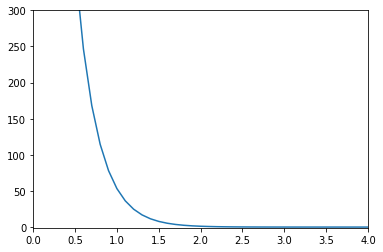

In [213]:
plot_buckingham_potential(2457.243, 0.2610,  0.00, r_range=[0,5])

In [223]:
build_ip_matrix(structure, {'C-C' : [1.,1.,0.]} , max_neigh=3)

array([[0.        , 0.08477793, 0.08477793, 0.08477793, 0.08477793,
        0.        , 0.08477793, 0.        , 0.08477793, 0.240571  ,
        0.240571  , 0.        , 0.        , 0.05787441, 0.        ,
        0.240571  , 0.05787441, 0.05787441],
       [0.        , 0.        , 0.08477793, 0.        , 0.08477793,
        0.08477793, 0.08477793, 0.08477793, 0.        , 0.        ,
        0.240571  , 0.240571  , 0.        , 0.        , 0.05787441,
        0.05787441, 0.240571  , 0.05787441],
       [0.        , 0.        , 0.        , 0.08477793, 0.        ,
        0.08477793, 0.        , 0.08477793, 0.08477793, 0.240571  ,
        0.        , 0.240571  , 0.05787441, 0.        , 0.        ,
        0.05787441, 0.05787441, 0.240571  ],
       [0.        , 0.        , 0.        , 0.        , 0.08477793,
        0.08477793, 0.08477793, 0.08477793, 0.        , 0.240571  ,
        0.05787441, 0.05787441, 0.240571  , 0.240571  , 0.        ,
        0.        , 0.05787441, 0.        ],
    

In [127]:
{'C-C' : [0.,1.,2.]}

{'C-C': [0.0, 1.0, 2.0]}

In [130]:
structure.sites[0].specie.symbol

'C'

In [122]:
np.where(np.unique(structure.atomic_numbers) == 6)[0]

array([0])

In [74]:
max_neigh = 1

distance_matrix = np.round(structure.distance_matrix,5)
shells = np.unique(np.round(distance_matrix,5))

distance_matrix_filter = distance_matrix == -1
for neigh in range(1,max_neigh+1):
    distance_matrix_filter +=  distance_matrix == shells[neigh]

distance_matrix = distance_matrix*distance_matrix_filter.astype(int)
distance_matrix

array([[0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 1.42474, 1.42474, 0.     , 0.     , 0.     ,
        0.     , 1.42474, 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 1.42474, 1.42474, 0.     , 0.     ,
        0.     , 0.     , 1.42474, 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 1.42474, 0.     , 1.42474, 0.     , 0.     ,
        0.     , 0.     , 0.     , 1.42474],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 1.42474, 0.     , 0.     , 1.42474, 1.42474,
        0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 1.42474, 0.     , 0.     , 1.42474,
        1.42474, 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0. 

# Graphene

## Build structure

In [332]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 2
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
#graphene_supercell

In [94]:
for i in range(0,18,2):
    graphene_supercell.replace(i,'N')

In [95]:
view(AseAtomsAdaptor().get_atoms(graphene_supercell))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [228]:
bqm = build_quadratic_model(graphene_supercell,num_vacancies=1)
#dataframe, config, energy = run_anneal(bqm,num_reads=100, return_config_E=True)

Unconstrained quadratic model + contraints used


In [229]:
a = run_anneal(bqm,num_reads=100, return_config_E=False, dataframe=False)

In [230]:
a

SampleSet(rec.array([([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], -192., 1, 0.        ),
           ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], -192., 1, 0.        ),
           ([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], -192., 2, 0.        ),
           ([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], -192., 2, 0.        ),
           ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], -192., 1, 0.        ),
           ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], -192., 1, 0.        ),
           ([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], -192., 1, 0.        ),
           ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], -192., 3, 0.        ),
           ([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], -192., 1, 0.        ),
           ([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], -192., 1, 0.        ),
           ([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], -192., 4, 0.

In [74]:
find_unique_E_structures(energy,config)

(array([-178., -168., -167.]), array([ 0,  5, 16]))

In [88]:
np.unique(energy,return_index=True)

(array([-178., -168., -167.,  808.,  837.,  846.,  847.,  856.,  857.,
         858.,  859., 3873., 3885., 8887.]),
 array([ 0,  5, 16, 27, 28, 32, 35, 52, 56, 74, 78, 80, 81, 82]))

In [86]:
display_low_E_structures(graphene_supercell,energy, config)

2022-06-24 16:17:30.525 python[15309:204905] *** CFMessagePort: bootstrap_register(): failed 1100 (0x44c) 'Permission denied', port = 0x14c07, name = 'python.ServiceProvider'
See /usr/include/servers/bootstrap_defs.h for the error codes.


In [87]:
#view(AseAtomsAdaptor().get_atoms(graphene_supercell),)

In [640]:
from dimod import ExactSolver, ExactCQMSolver

df = ExactCQMSolver().sample_cqm(cqm).to_pandas_dataframe()

In [642]:
df[df['energy'] < 0.]
df[df['is_satisfied'] == True]

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,energy,is_feasible,is_satisfied,num_occurrences
65535,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,-21.0,True,True,1
98303,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,0,-21.0,True,True,1
114687,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,0,-21.0,True,True,1
122879,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0,-21.0,True,True,1
126975,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,-21.0,True,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262133,0,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,-21.0,True,True,1
262134,1,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,-21.0,True,True,1
262137,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,-21.0,True,True,1
262138,1,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,-21.0,True,True,1


### Calculations

#### 1 vacancy - test configuration

#### BQM

In [331]:
bqm = build_quadratic_model(graphene_supercell,weight_1=1,use_coord=False,num_vacancies=1)
dataframe, config, energy = run_anneal(bqm,num_reads=1000, return_config_E=True)

Unconstrained quadratic model + contraints used


In [332]:
dataframe[dataframe['energy'] < 0]

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,0.0,-24.0,16
1,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.0,-24.0,12
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.0,-24.0,6
3,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,0.0,-24.0,18
4,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,0.0,-24.0,11
5,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0.0,-24.0,7
6,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,0.0,-24.0,10
7,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,0.0,-24.0,11
8,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,0.0,-24.0,2
9,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0.0,-24.0,12


In [333]:
np.sum(dataframe[dataframe['energy'] < 0]['num_occurrences'].to_numpy())

177

#### CQM

In [367]:
cqm = build_constrained_quadratic_model(graphene_supercell,weight_1=1,use_coord=False,num_vacancies=2)
#dataframe, config, energy = run_anneal(cqm,time_limit=5, return_config_E=True)

Constrained quadratic model


In [370]:
from dwave.system import LeapHybridCQMSampler
cqm_sampler = LeapHybridCQMSampler()
sampleset_2 = cqm_sampler.sample_cqm(cqm,time_limit=10)

In [374]:
df = sampleset.to_pandas_dataframe()
df[df['is_feasible']]

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,energy,is_feasible,is_satisfied,num_occurrences
0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-22.0,True,True,1
8,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-22.0,True,True,1
9,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,-22.0,True,True,1
15,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-22.0,True,True,1
16,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,-22.0,True,True,1
17,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-22.0,True,True,1
18,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-22.0,True,True,1
19,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-22.0,True,True,1
20,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,-22.0,True,True,1
21,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,-22.0,True,True,1


In [372]:
sampleset_2

SampleSet(rec.array([([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.], -24., 1, False, [False]),
           ([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.], -22., 1,  True, [ True]),
           ([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], -24., 1, False, [False]),
           ([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.], -24., 1, False, [False]),
           ([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], -24., 1, False, [False]),
           ([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], -24., 1, False, [False]),
           ([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], -24., 1, False, [False]),
           ([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.], -24., 1, False, [False]),
           ([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.], -24., 1,

# Diamond

## Build structure

In [100]:
with MPRester("p5vAQV3F1QuxFcxVT") as m:    
    diamond = m.get_structure_by_material_id("mp-66")

In [101]:
view(AseAtomsAdaptor().get_atoms(diamond))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [102]:
#diamond = SpacegroupAnalyzer(diamond).get_conventional_standard_structure()

n_supercell = 2
scaling_matrix = np.identity(3)*n_supercell
diamond_supercell = copy.deepcopy(diamond)
diamond_supercell.make_supercell(scaling_matrix)

In [103]:
view(AseAtomsAdaptor().get_atoms(diamond_supercell))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [105]:
build_adjacency_matrix(diamond_supercell)

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
       [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [128]:
bqm = build_quadratic_model(diamond_supercell,num_vacancies=3)

Unconstrained quadratic model + contraints used


In [130]:
dataframe, config, energy = run_anneal(bqm,num_reads=500, return_config_E=True)

In [239]:
energy_unique, config_unique = find_unique_E_structures(energy,config)
display(energy_unique)
display(config_unique)

array([-158., -150., -148., -138., -136., -134.])

array([  0,  33,  55, 122, 155, 166])

In [292]:
low_energy_structures = display_low_E_structures(diamond_supercell,energy, config)

In [293]:
view(low_energy_structures[-1])

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [291]:
coordination, coord_analysis = find_coordination(diamond_supercell,config,config_unique, return_analysis=True)

In [252]:
broken_bonds = find_num_broken_bonds(diamond_supercell,config,config_unique)

In [300]:
coord_analysis = np.array(coord_analysis)
df = pd.DataFrame(list(zip(energy_unique,broken_bonds,coord_analysis[:,0],
                          coord_analysis[:,1], coord_analysis[:,2], coord_analysis[:,3])),
                      columns=['Energy','N broken bonds',
                              '4 coord', '3 coord', '2 coord', '1 coord'],
                      index=config_unique)
df

,Energy,N broken bonds,4 coord,3 coord,2 coord,1 coord
0,-158.0,10.0,6,6,1,0
33,-150.0,11.0,3,10,0,0
55,-148.0,11.0,5,6,2,0
122,-138.0,12.0,3,8,2,0
155,-136.0,12.0,5,4,4,0
166,-134.0,12.0,6,3,3,1


array([0.     , 2.56062, 3.62126, 4.43512, 5.12124, 6.27221])

In this model, we are only interested in the nearest neighbours, i.e. the ones in the first coordination shell, which corresponds to the element in position 1 of the array above (remember that in python we start counting from 0). Therefore, we can combine the information contained in the 

# Copper

## Build structure

In [55]:
lattice = np.array([[0.      , 1.810631, 1.810631],
                   [1.810631, 0.      , 1.810631],
                   [1.810631, 1.810631, 0.      ]])

copper = Structure(lattice, species=['Cu'], coords=[[0., 0., 0. ]])

copper = SpacegroupAnalyzer(copper).get_conventional_standard_structure()

n_supercell = 2
scaling_matrix = np.identity(3)*n_supercell
copper_supercell = copy.deepcopy(copper)
copper_supercell.make_supercell(scaling_matrix)

In [45]:
view(AseAtomsAdaptor().get_atoms(copper_supercell))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [41]:
bqm = build_quadratic_model(copper_supercell,num_vacancies=1, weight_1=1)
#dataframe, config, energy = run_anneal(bqm,num_reads=100, return_config_E=True)

[[0. 8. 8. ... 4. 3. 4.]
 [0. 0. 4. ... 3. 4. 3.]
 [0. 0. 0. ... 4. 3. 4.]
 ...
 [0. 0. 0. ... 0. 4. 8.]
 [0. 0. 0. ... 0. 0. 8.]
 [0. 0. 0. ... 0. 0. 0.]]
Unconstrained quadratic model + contraints used
[[-61000.   2008.   2008. ...   2004.   2003.   2004.]
 [     0. -61000.   2004. ...   2003.   2004.   2003.]
 [     0.      0. -61000. ...   2004.   2003.   2004.]
 ...
 [     0.      0.      0. ... -61000.   2004.   2008.]
 [     0.      0.      0. ...      0. -61000.   2008.]
 [     0.      0.      0. ...      0.      0. -61000.]]


/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_13721/4185597591.py:23: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0 and will be removed in 0.12.0
  print(bqm.to_numpy_matrix())
/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_13721/4185597591.py:38: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0 and will be removed in 0.12.0
  print(bqm.to_numpy_matrix())


In [43]:
build_adjacency_matrix(copper_supercell)[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [52]:
distance_matrix_pbc = np.round(copper_supercell.distance_matrix,5)

shells = np.unique(distance_matrix_pbc[0])

adjacency_matrix = np.round(distance_matrix_pbc,5) == np.round(shells[1],5)
adjacency_matrix = adjacency_matrix.astype(int)
np.sum(adjacency_matrix,axis=1)

array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12])

In [57]:
np.round(copper_supercell.distance_matrix,5)[0]

array([0.     , 3.62126, 3.62126, 5.12124, 3.62126, 5.12124, 5.12124,
       6.27221, 2.56062, 2.56062, 2.56062, 2.56062, 4.43512, 4.43512,
       4.43512, 4.43512, 2.56062, 2.56062, 4.43512, 4.43512, 2.56062,
       2.56062, 4.43512, 4.43512, 2.56062, 4.43512, 2.56062, 4.43512,
       2.56062, 4.43512, 2.56062, 4.43512])

# Binary material

### Make simple square model

In [645]:
from pymatgen.core.structure import Structure
lattice = np.array([[2.      , 0., 0.],
                   [0., 2.      , 0.],
                   [0., 0., 2.      ]])

structure = Structure(lattice, species=['Cu'], coords=[[0., 0., 0. ]])

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1.
structure.make_supercell(scaling_matrix)

In [648]:
adjacency_matrix = build_adjacency_matrix(structure)
adjacency_matrixb

array([[0, 1, 1, 1, 0, 0, 1, 0, 0],
       [1, 0, 1, 0, 1, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 0, 0, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 1, 1, 1, 0]])

In [659]:
import dimod

from dwave.system import LeapHybridDQMSampler

dqm = dimod.DiscreteQuadraticModel()
n_clusters = 2
n_nodes = structure.num_sites
beta = 3
cu_cu = -2.
zn_zn = -1.
cu_zn = -3

for i in range(structure.num_sites):
    dqm.add_variable(n_clusters, label=i)

#linked atoms
for i in range(structure.num_sites):
    for j in np.where(adjacency_matrix[i] == 1)[0]:
        #print(i,j)
        dqm.set_quadratic(i, j, {(0, 0): cu_cu, (0, 1): cu_zn, (1, 1): zn_zn})
        
sampler = LeapHybridDQMSampler()
sampleset = sampler.sample_dqm(dqm, label='DQM first attempt')
        
#Add the concentration constraint

In [660]:
sampleset.to_pandas_dataframe()

,0,1,2,3,4,5,6,7,8,energy,num_occurrences
0,1,0,0,0,0,1,0,1,0,-48.0,1
1,0,1,0,0,0,1,1,0,0,-48.0,1
2,0,1,0,1,0,0,0,0,1,-48.0,1
3,1,0,0,0,1,0,0,0,1,-48.0,1
4,1,0,0,0,1,0,0,0,1,-48.0,1
5,0,1,0,0,0,1,1,0,0,-48.0,1
6,1,0,0,0,0,1,0,1,0,-48.0,1
7,0,1,0,0,0,1,1,0,0,-48.0,1
8,1,0,0,0,0,1,0,1,0,-48.0,1
9,0,0,1,0,1,0,1,0,0,-48.0,1


In [655]:
dqm.to_numpy_vectors()

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_13721/296124909.py:1: DeprecationWarning: `return_offset` will default to `True` in the future.
  dqm.to_numpy_vectors()


LegacyDQMVectors(case_starts=array([ 0,  2,  4,  6,  8, 10, 12, 14, 16], dtype=uint16), linear_biases=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), quadratic=QuadraticVectors(row_indices=array([ 2,  2,  3,  3,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  7,  7,  8,
        8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15,
       15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17,
       17, 17, 17, 17], dtype=uint16), col_indices=array([ 0,  1,  0,  1,  0,  1,  2,  3,  0,  1,  2,  3,  0,  1,  0,  1,  2,
        3,  6,  7,  2,  3,  6,  7,  4,  5,  6,  7,  8,  9,  4,  5,  6,  7,
        8,  9,  0,  1,  6,  7,  0,  1,  6,  7,  2,  3,  8,  9, 12, 13,  2,
        3,  8,  9, 12, 13,  4,  5, 10, 11, 12, 13, 14, 15,  4,  5, 10, 11,
       12, 13, 14, 15], dtype=uint16), biases=array([2., 3., 3., 1., 2., 3., 2., 3., 3., 1., 3., 1., 2., 3., 3., 1., 2.,